<a href="https://colab.research.google.com/github/fancyparis9456/Deep-Learning/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E6%9C%9F%E6%9C%AB_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
seed_value= 2

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

# Basic packages always been used
import pandas as pd
import numpy as np
np.random.seed(seed_value)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [135]:
# Colab
data = pd.read_csv('/content/drive/MyDrive/DL/META.csv')
data

,Date,Close
0,2013/6/10,24.330000
1,2013/6/11,24.030001
2,2013/6/12,23.770000
3,2013/6/13,23.730000
4,2013/6/14,23.629999
...,...,...
2514,2023/6/5,271.390015
2515,2023/6/6,271.119995
2516,2023/6/7,263.600006
2517,2023/6/8,264.579987


In [136]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   Close   2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


,Close
count,2519.000000
mean,163.038781
std,80.149169
min,23.629999
25%,102.065002
50%,160.979996
75%,200.695000
max,382.179993


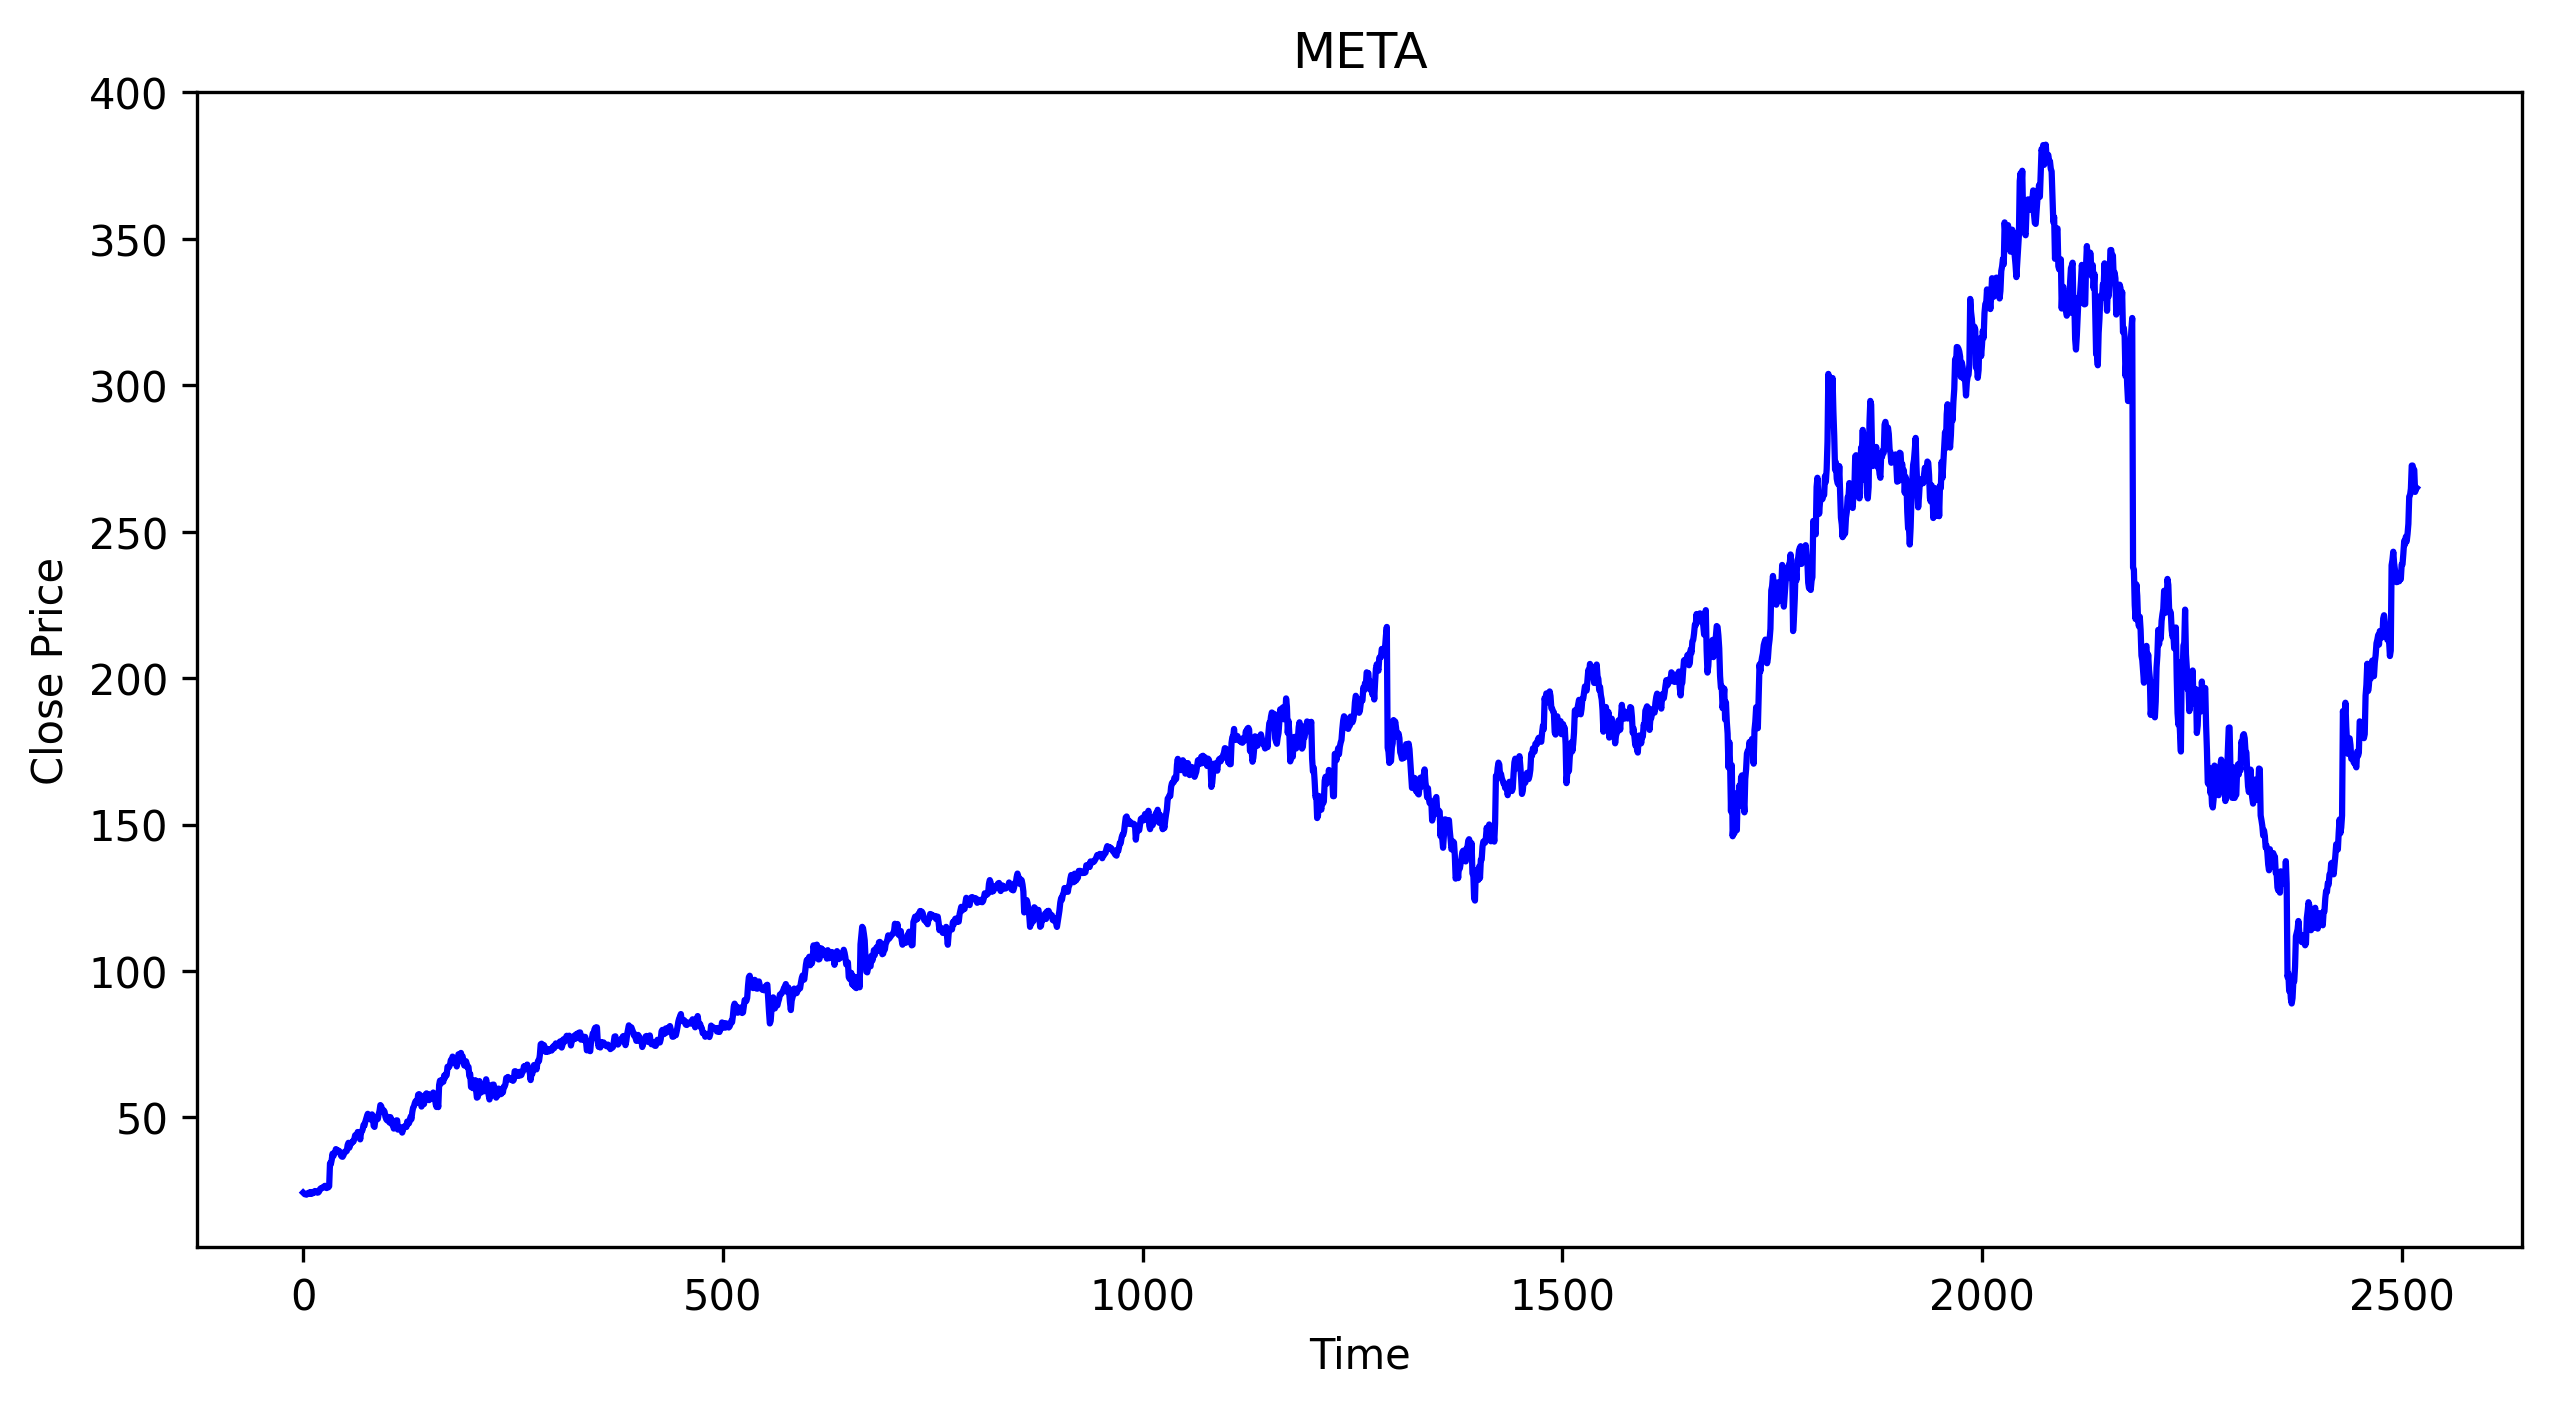

In [137]:
data=data['Close']
plt.figure(figsize=(10,5),dpi=300)
plt.plot(data, color ='blue');
plt.ylabel('Close Price')
plt.title('META')
plt.xlabel('Time')
plt.show()

In [138]:
split =int(0.8*data.shape[0])
Train,Test  = data[0:split] , data[split:]

val_split=int(0.8*Train.shape[0])
Train,Val=Train[0:val_split] , Train[val_split:]
Val=Val.reset_index(drop=True)
Test=Test.reset_index(drop=True)

In [139]:
Test

0      332.459991
1      331.260010
2      336.769989
3      336.750000
4      331.079987
          ...    
499    271.390015
500    271.119995
501    263.600006
502    264.579987
503    264.950012
Name: Close, Length: 504, dtype: float64

In [140]:
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1) 
train_set= Train.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(train_set)
val_set= Val.values.reshape(-1,1)
val_set_scaled = sc.transform(val_set)
test_set = Test.values.reshape(-1,1)
test_set_scaled = sc.transform(test_set)

X_train = [] 
y_train = []
for i in range(5,len(train_set)):
    X_train.append(training_set_scaled[i-5:i]) 
    y_train.append(training_set_scaled[i]) 
X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = [] 
y_val = []
for i in range(5,len(val_set)):
    X_val.append(val_set_scaled[i-5:i]) 
    y_val.append(val_set_scaled[i]) 
X_val, y_val = np.array(X_val), np.array(y_val) 
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(5,len(test_set)):
    X_test.append(test_set_scaled[i-5:i]) 
    y_test.append(test_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test) 
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [141]:
X_train[0]

array([[0.00361067],
       [0.00206325],
       [0.00072214],
       [0.00051581],
       [0.        ]])

In [142]:
keras.backend.clear_session()
model = Sequential()
model.add(GRU(units = 64,return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(GRU(units = 32,activation='relu'))
model.add(Dense(units = 1))
model.summary()
opt=Adam(learning_rate=0.0005,beta_1=0.95)
model.compile(optimizer = opt, loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             12864     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data=(X_val,y_val))

Epoch 1/100
51/51 [==============================] - 5s 28ms/step - loss: 0.0865 - val_loss: 0.0147
Epoch 2/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 3/100
51/51 [==============================] - 2s 35ms/step - loss: 9.8692e-04 - val_loss: 0.0017
Epoch 4/100
51/51 [==============================] - 2s 33ms/step - loss: 5.6951e-04 - val_loss: 0.0020
Epoch 5/100
51/51 [==============================] - 1s 17ms/step - loss: 5.8695e-04 - val_loss: 0.0016
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 5.7721e-04 - val_loss: 0.0016
Epoch 7/100
51/51 [==============================] - 1s 20ms/step - loss: 5.8148e-04 - val_loss: 0.0016
Epoch 8/100
51/51 [==============================] - 1s 20ms/step - loss: 5.9203e-04 - val_loss: 0.0016
Epoch 9/100
51/51 [==============================] - 1s 19ms/step - loss: 5.4159e-04 - val_loss: 0.0016
Epoch 10/100
51/51 [==============================] - 1s 19ms/step - los

In [144]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'val_loss'])

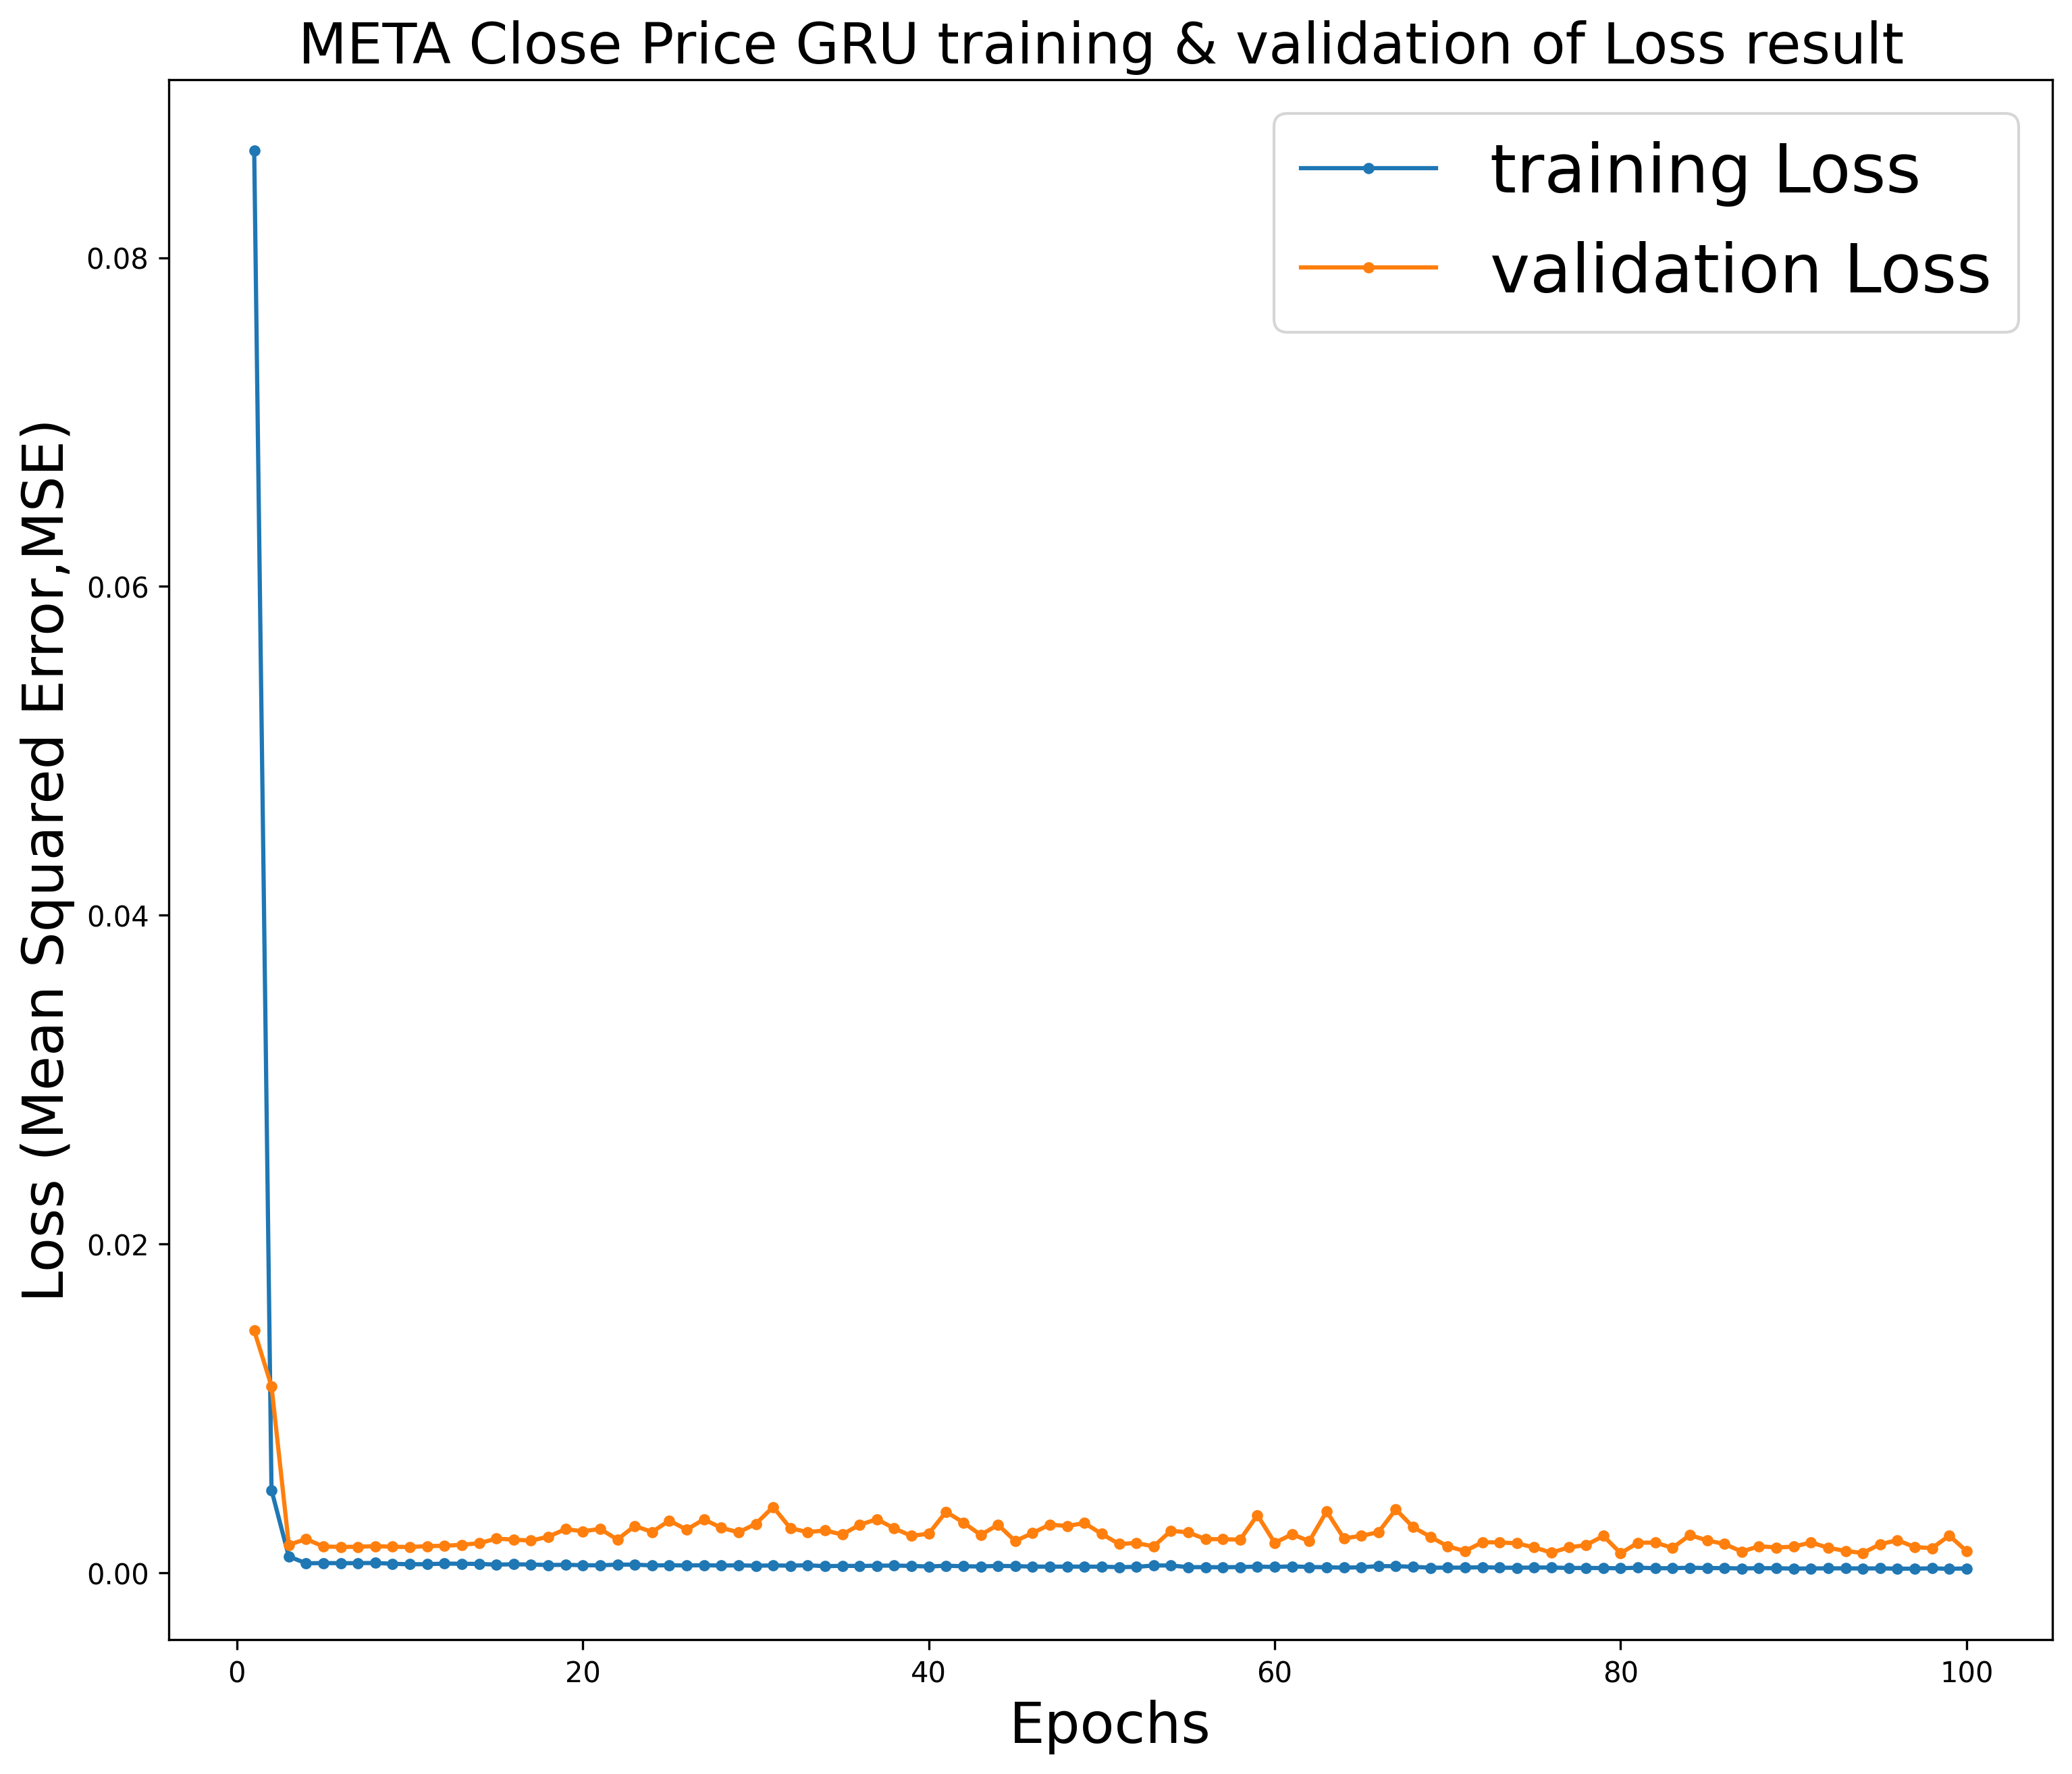

In [145]:
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('META Close Price GRU training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [146]:
predicted_price = model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)

16/16 [==============================] - 0s 3ms/step


In [147]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output2.csv', index=False)

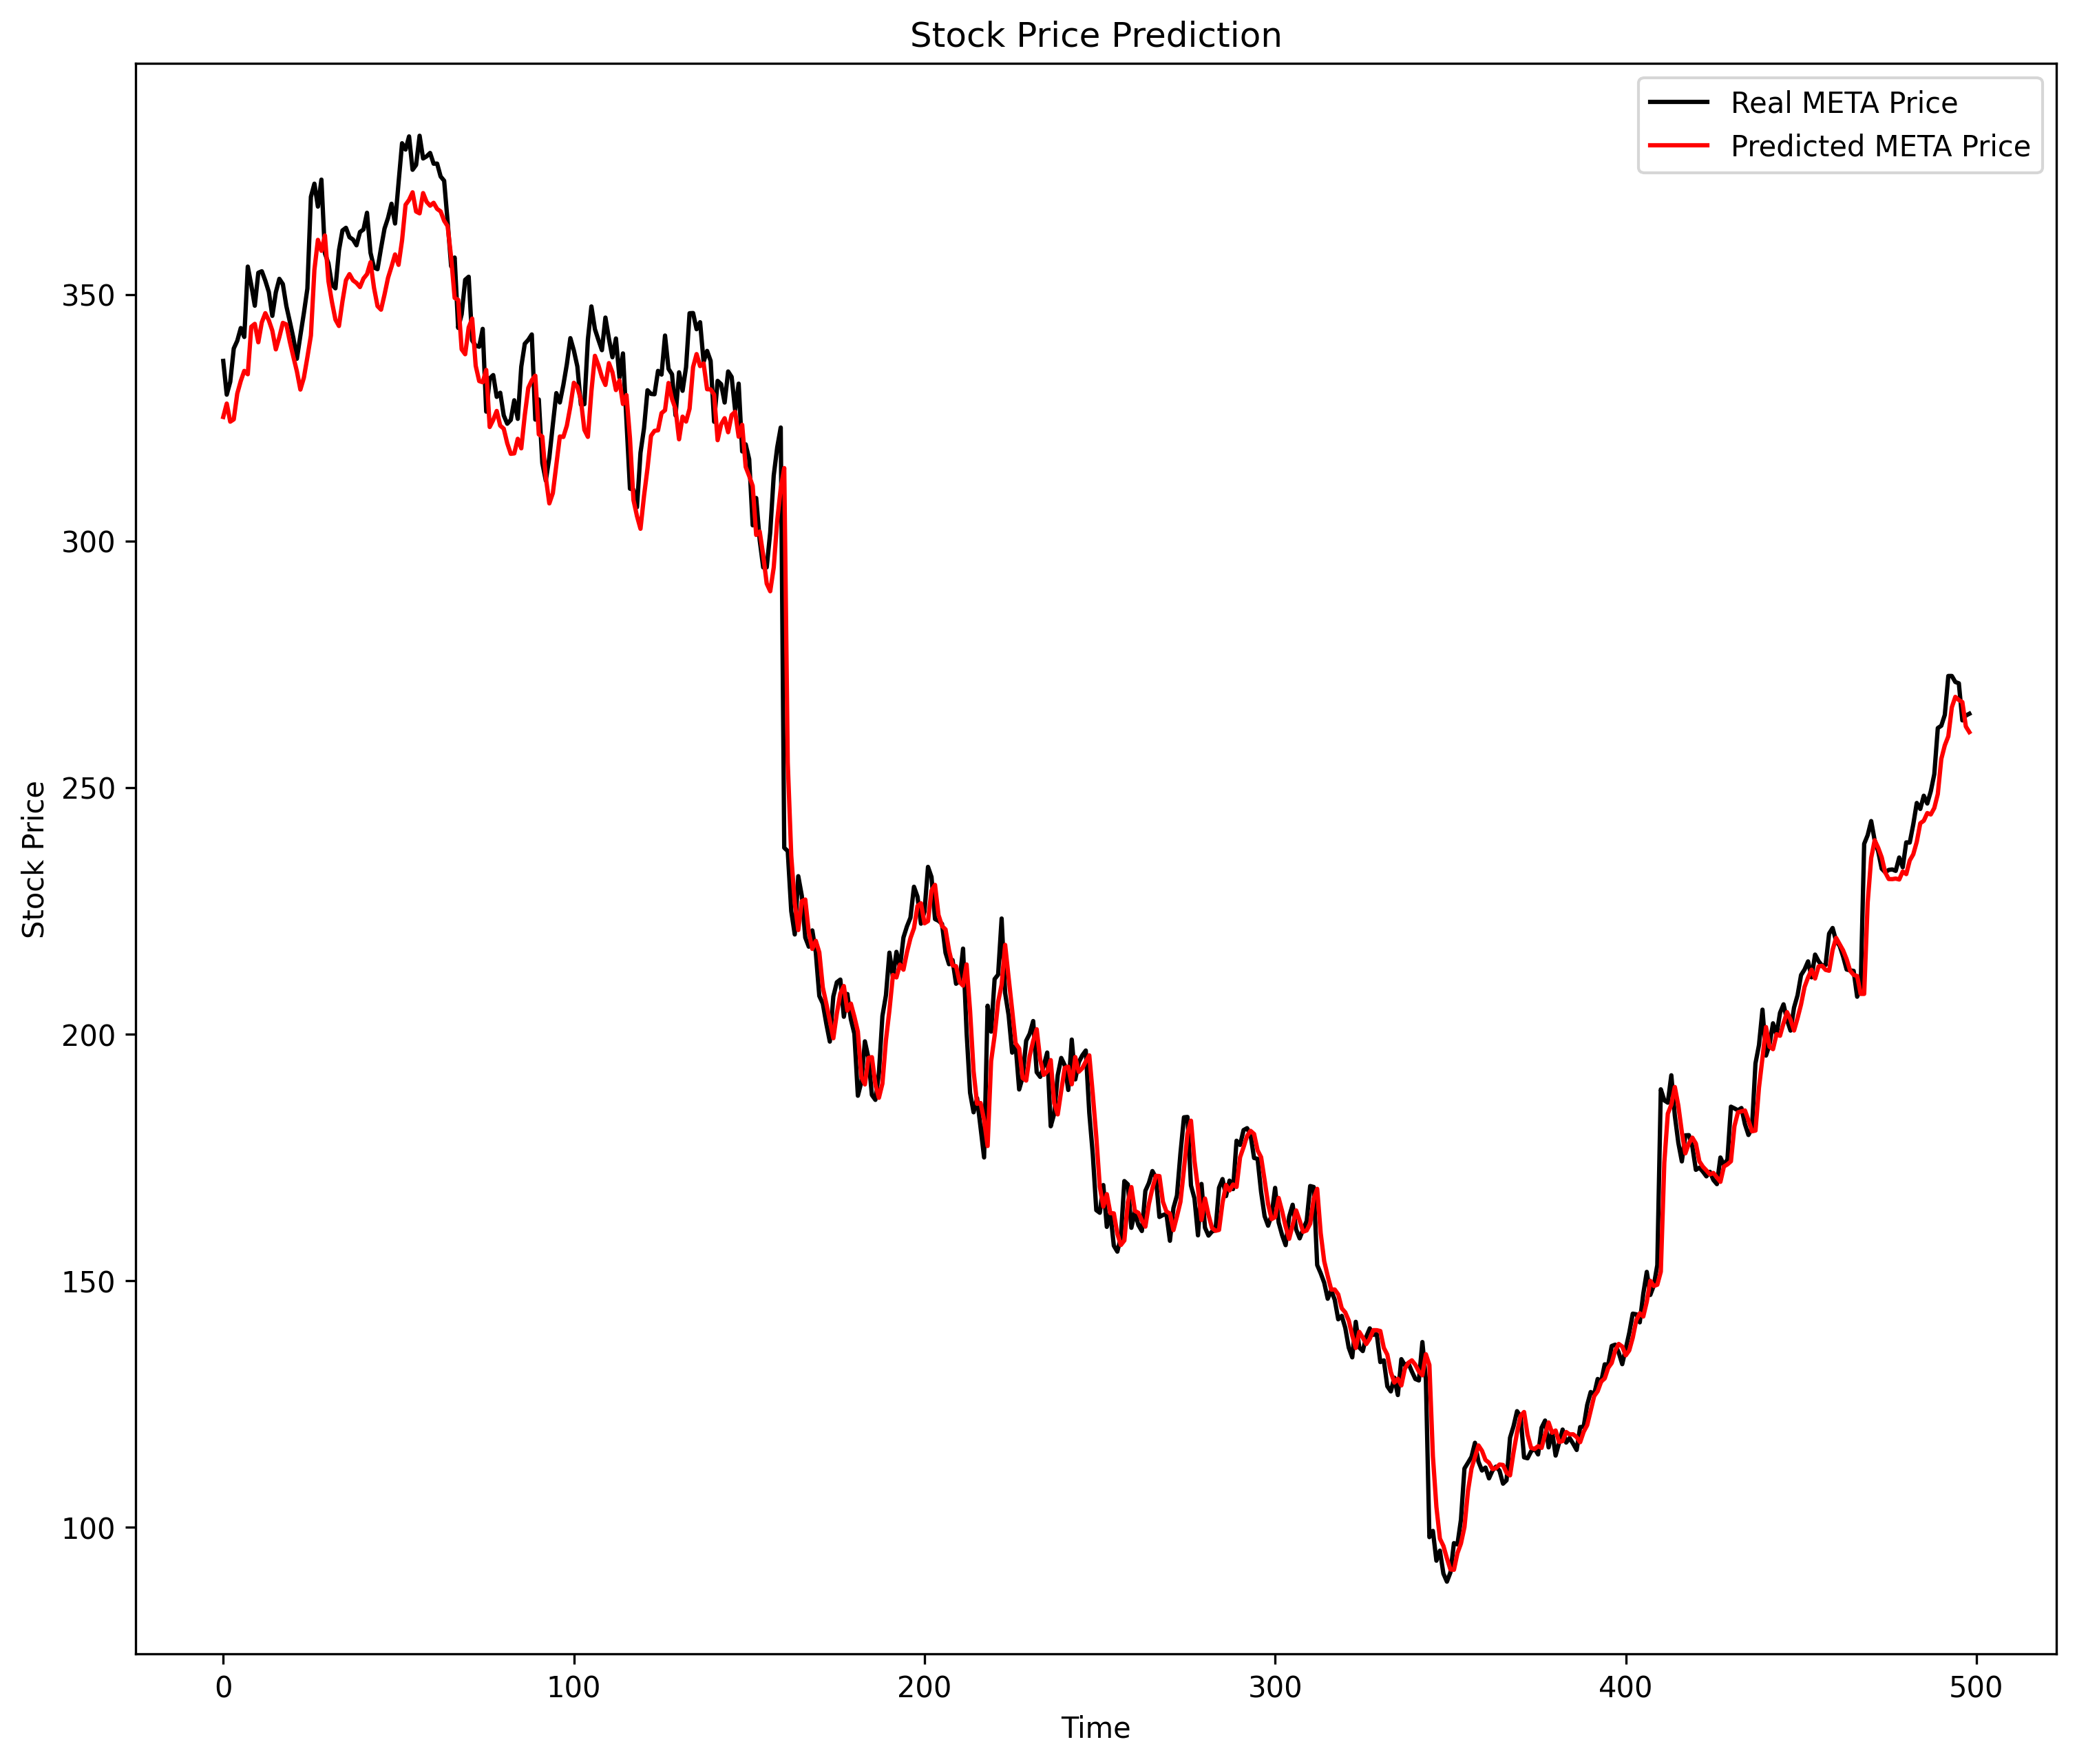

In [150]:
plt.figure(figsize=(12,10),dpi=300)
plt.plot(actual_price, color = 'black', label = 'Real META Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted META Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [151]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [152]:
predicted_price
actual_price

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
MAPE=mean_absolute_percentage_error(actual_price,predicted_price)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
RAE=RAE_calculate(actual_price,predicted_price)
MRAE=MRAE_calculate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)
RSE=RSE_calculate(actual_price,predicted_price,Root=False)
RRSE=RSE_calculate(actual_price,predicted_price,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 6.174
MSE: 74.339
RMSE: 8.622
MAPE: 2.76 %
SMAPE: 2.757 %
RAE: 0.083
MRAE: 0.00016671045482804747
MdRAE: 0.072 bench: 230.188
RSE: 0.01
RRSE: 0.102
